# Prerequisites

In [1]:
!pip install simpletransformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB

In [4]:
import pandas as pd
import torch
import numpy as np
import csv

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available! Running on GPU.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Running on CPU.')

# Set a random seed for reproducibility
SEED = 2137
torch.manual_seed(SEED)

# Clear any cached memory
torch.cuda.empty_cache()

# Check if CUDA is available
print('Is CUDA available?', torch.cuda.is_available())

CUDA is available! Running on GPU.
Is CUDA available? True


In [5]:
!nvidia-smi

Sun Apr 21 10:27:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Get the data

In [8]:
import zipfile
import os

use_google_drive = True

if use_google_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv("/content/drive/MyDrive/data_processed_1M.csv", header=0, nrows=125000)

else:
  data = pd.read_csv("data_processed_balanced_125k.csv", header=0)

tokenizer_dir = "bert_save/tokenizer"
model_dir = "bert_save/model"

if use_google_drive:
  zip_file_path = "/content/drive/MyDrive/bert_save.zip"
else:
  zip_file_path = "bert_save.zip"

extract_dir = "bert_save"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,rating
0,We went here with our kids for Xmas holiday an...,4
1,We have spent in this hotel our summer holiday...,4
2,I visited Hotel Baltic with my husband for som...,4
3,I've travelled quite a numbers of hotels but t...,4
4,We decided for this family holiday destination...,3


# Since the data is organized, we need to shuffle it


In [11]:
data = data.sample(frac=1)
data.head()

,text,rating
114672,This hotel is walking distance from most of th...,2
7560,The location was perfect for me as I was atten...,1
100231,We stayed 3 nights at this hotel and found it ...,3
82382,This is a hotel in a lovely setting overlookin...,4
64738,We are Platimum Rewards members so we were upg...,4


In [12]:
print(data)

                                                     text  rating
114672  This hotel is walking distance from most of th...       2
7560    The location was perfect for me as I was atten...       1
100231  We stayed 3 nights at this hotel and found it ...       3
82382   This is a hotel in a lovely setting overlookin...       4
64738   We are Platimum Rewards members so we were upg...       4
...                                                   ...     ...
109512  Hotel is situated on a square with various bar...       3
76697   We have loved our stay at Aratinga Inn. Rennie...       4
32612   This place is fantastic. We would love to retu...       4
20551   We stayed in a one bedroom apartment. Living a...       3
45468   1st class hotel with breakfast included. Locat...       4

[125000 rows x 2 columns]


# Data actions

### Tokenize inputs

In [13]:
from transformers import BertTokenizer

MAX_LEN = 128

# Load BERT tokenizer
try:
  # Check if it's storred locally
  print("Trying to get the tokenizer from local files...")
  tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
  print(">>> Done!")
except:
  print("Tokenizer save not found, training a new one...")
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input data
encodings = tokenizer(data['text'].tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')

# Convert ratings to tensor
labels = torch.tensor(data['rating'].tolist())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

Trying to get the tokenizer from local files...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer save not found, training a new one...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Split the data

In [14]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids, attention_masks,
                                                            random_state=SEED, test_size=0.10, stratify = labels)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

<ipython-input-14-4a5d67c927e5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-14-4a5d67c927e5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-14-4a5d67c927e5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
<ipython-input-14-4a5d67c927e5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

### Prepare dataloaders

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)


# Train the model

In [16]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm
from matplotlib import pyplot as plt

LEARNING_RATE = 2e-5
NUM_EPOCHS = 1

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
  model = BertForSequenceClassification.from_pretrained(model_dir).to(device)
except:
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)  # 5 because ratings are from 0 to 4

  # Define optimizer and scheduler
  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

  train_losses = []
  val_losses = []

  # Training loop
  for epoch in range(NUM_EPOCHS):
      # Training
      model.train()
      total_loss = 0
      progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)
      for batch in progress_bar:
          b_input_ids, b_input_mask, b_labels, b_token_types = batch
          # Move tensors to GPU
          b_input_ids = b_input_ids.to(device)
          b_input_mask = b_input_mask.to(device)
          b_labels = b_labels.to(device)

          optimizer.zero_grad()
          outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
          loss = outputs.loss
          total_loss += loss.item()
          loss.backward()
          optimizer.step()
          progress_bar.set_postfix({'batch_loss': loss.item()})
      avg_train_loss = total_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)

      # Validation
      model.eval()
      total_eval_loss = 0
      with torch.no_grad():
          for batch in validation_dataloader:
              b_input_ids, b_input_mask, b_labels, b_token_types = batch
              # Move tensors to GPU
              b_input_ids = b_input_ids.to(device)
              b_input_mask = b_input_mask.to(device)
              b_labels = b_labels.to(device)

              outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
              loss = outputs.loss
              total_eval_loss += loss.item()
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      val_losses.append(avg_val_loss)

      print(f'Epoch {epoch+1}:')
      print(f'Training Loss: {avg_train_loss}')
      print(f'Validation Loss: {avg_val_loss}')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1:
Training Loss: 0.7117563045591082
Validation Loss: 0.6906036156827532


[0.7117563045591082]


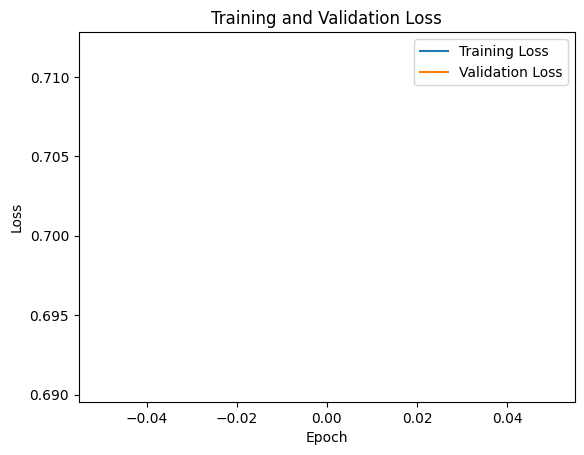

In [17]:
# Plot loss over time
print(train_losses)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Model tests

In [18]:
def predict_rating(review_text):
    # Tokenize input text
    inputs = tokenizer(review_text, return_tensors='pt', max_length=128, truncation=True, padding=True)

    # Move input tensors to the appropriate device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (rating)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Example usage
custom_reviews = ["This hotel was great! Wonderful service and comfortable rooms.", "Not bad"]
for custom_review in custom_reviews:
  predicted_rating = predict_rating(custom_review)
  print(f"{custom_review}: >> {predicted_rating} <<")

This hotel was great! Wonderful service and comfortable rooms.: >> 4 <<
Not bad: >> 2 <<


# Evaluation

In [19]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Evaluation
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        # Move tensors to GPU
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Classification report
print(classification_report(all_labels, all_predictions, digits=4))

Accuracy: 0.6908
Precision: 0.6972381352364891
Recall: 0.6908
F1-score: 0.6908708125956269
              precision    recall  f1-score   support

           0     0.5196    0.7477    0.6131       444
           1     0.4260    0.2193    0.2896       538
           2     0.5003    0.6243    0.5554      1352
           3     0.5600    0.5670    0.5635      3446
           4     0.8407    0.8016    0.8207      6720

    accuracy                         0.6908     12500
   macro avg     0.5693    0.5920    0.5685     12500
weighted avg     0.6972    0.6908    0.6909     12500



# Save model

In [ ]:
# SAVE MODEL
import os
import re
import shutil
from datetime import datetime

dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

output_dir = f"outputs/{dt_string}_{accuracy}ACC"

# Save the model and its configuration
model.save_pretrained(f"{output_dir}/model")

# Save the tokenizer as well
tokenizer.save_pretrained(f"{output_dir}/tokenizer")

('outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/tokenizer_config.json',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/special_tokens_map.json',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/vocab.txt',
 'outputs/27-03-2024-18-10-44_0.62144ACC/tokenizer/added_tokens.json')

# Download model

In [ ]:
from google.colab import files

shutil.make_archive(output_dir, 'zip', output_dir)

# Download the zip file
files.download(output_dir + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>